In [ ]:
!pip install pandas
!pip install scipy
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 50.9 MB/s eta 0:00:00


In [198]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, silhouette_samples
import seaborn as sns

In [ ]:
# Global variables to store data
raw_lines = None
df_spectrogram = None
canvas = None  # Canvas for Matplotlib
toolbar = None  # Toolbar for navigation

# Function to read header parameters
def read_header_parameters(raw_lines):
    header_parameters = {}
    processing_header = True

    for i, line in enumerate(raw_lines):
        if processing_header:
            if not line.strip():
                break
            key_value = line.strip().split(',')
            if len(key_value) >= 2:
                header_parameters[key_value[0].strip()] = key_value[1].strip()

    return header_parameters

# Function to read averages data
def read_averages(raw_lines):
    averages = []
    averages_section_started = False

    for i, line in enumerate(raw_lines):
        if "Frequency [Hz]" in line:
            averages_section_started = True
            continue
        if averages_section_started:
            if not line.strip():
                break
            averages.append(line.strip().split(',')[:2])
    df_averages = pd.DataFrame(averages, columns=["Frequency [Hz]", "Magnitude [dBm]"])
    return df_averages

# Function to process spectrogram data
def process_spectrogram_data(raw_lines):
    timestamps_relative = None
    frequencies_and_magnitudes = []
    data_section_started = False

    for i, line in enumerate(raw_lines):
        if "Timestamp (Relative)" in line:
            timestamps_relative = line.strip().split(',')[1:]

        if "Frequency [Hz]" in line and timestamps_relative is not None:
            data_section_started = True
            continue

        if data_section_started:
            if line.strip():
                frequencies_and_magnitudes.append(line.strip().split(','))

    frequencies = [row[0] for row in frequencies_and_magnitudes]
    magnitudes = [row[1:] for row in frequencies_and_magnitudes]

    df = pd.DataFrame(magnitudes, index=frequencies, columns=timestamps_relative)

    return df

In [406]:
with open("./Senales/SPG_0019.csv", 'r') as file:
  raw_lines = file.readlines()
  # Process the data
  df_spectrogram = process_spectrogram_data(raw_lines)
  header_params = read_header_parameters(raw_lines)

In [ ]:
def identificarSenales(data):

  df = data.apply(pd.to_numeric, errors='coerce').fillna(0)

  df = df.drop(columns=[''])

  df['std_dev'] = df.std(axis=1)

  df_transposed = df.transpose()
  fft_results = df_transposed.apply(lambda x: np.fft.fft(x))
  fft_magnitudes = fft_results.apply(lambda x: np.abs(x))
  fft_features = fft_magnitudes.apply(lambda x: [np.max(x), np.sum(x), np.var(x)], axis=0)
  fft_features = pd.DataFrame(fft_features).transpose()
  fft_features.columns = ['max_magnitude', 'sum_magnitude', 'variance']

  df['mean_diff'] = df.diff(axis=1).mean(axis=1).abs()

  df['derivative'] = df.apply(lambda row: np.gradient(row.values), axis=1).apply(np.max)

  df['combined_score'] = df['std_dev'] + df['derivative'] + df["mean_diff"]


  return df

In [407]:
df_final = identificarSenales(df_spectrogram).sort_values(by=['std_dev'], ascending=False)

In [408]:
kmeans = KMeans(n_clusters=3, random_state=0)

res_kmeans = kmeans.fit(df_final)

centroides_escalados = kmeans.cluster_centers_

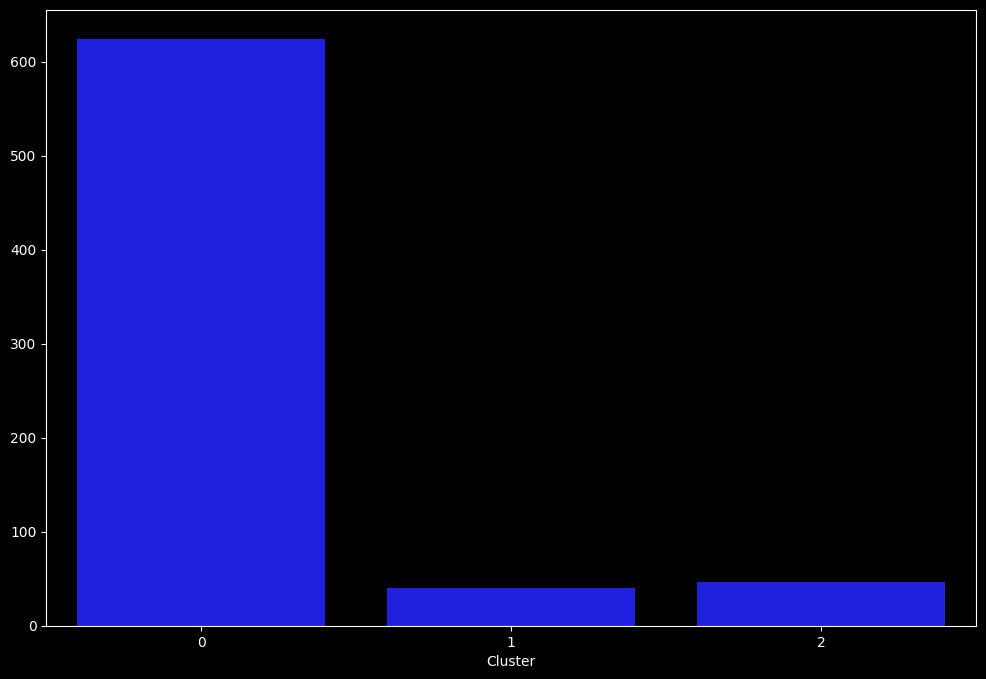

In [409]:
labels = res_kmeans.labels_
df_final['Cluster'] = labels
cluster_distrib = df_final['Cluster'].value_counts()
fig=plt.figure(figsize=(12,8))
sns.barplot(x=cluster_distrib.index, y=cluster_distrib.values, color='b');

In [410]:
def graficoClusters(type):
    # Convertir las frecuencias del índice a valores numéricos
    frequencies = pd.to_numeric(df_final.index)
    timestamps = np.arange(len(df_final.columns) - 5)  # Ajuste según el número de columnas que contengan amplitudes

    # Crear la malla de datos con frecuencia en X y tiempo en Y
    X, Y = np.meshgrid(frequencies, timestamps)

    # Obtener los clústeres únicos y definir los colores para cada uno
    unique_clusters = np.unique(df_final[type])
    palette = sns.color_palette("tab10", len(unique_clusters))  # Paleta de colores para los clústeres
    cluster_colors = {cluster: palette[i] for i, cluster in enumerate(unique_clusters)}

    # Crear la figura y ajustar el tamaño
    plt.figure(figsize=(14, 8))

    # Graficar los puntos con los colores correspondientes a cada clúster
    for i, freq in enumerate(frequencies):
        cluster_label = df_final[type].iloc[i]
        color = cluster_colors[cluster_label]
        plt.scatter(np.repeat(freq, len(timestamps)), timestamps, c=[color], s=20, alpha=0.75)

    # Ajustes de título y etiquetas, ahora con los ejes volteados
    plt.title("Espectrograma con Clústeres")
    plt.xlabel("Frecuencia (Hz)")
    plt.ylabel("Timestamps")
    plt.grid(True)

    # Crear una leyenda con los colores de los clústeres
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cluster_colors[c], markersize=10, label=f'Cluster {c}')
               for c in unique_clusters]
    plt.legend(handles=handles, title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Mostrar el gráfico
    plt.show()


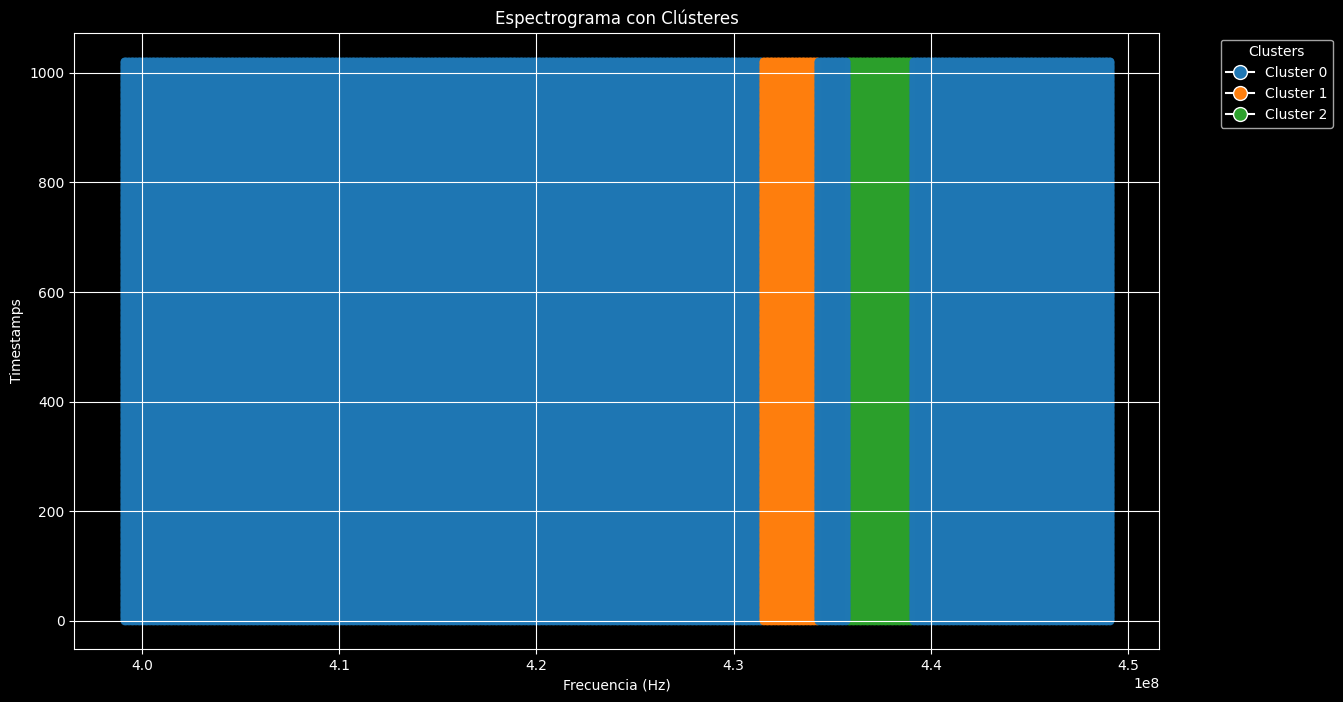

In [411]:
graficoClusters("Cluster")

In [436]:
def especSenal(cluster):
    df_cluster = df_final[df_final['Cluster'] == cluster]
    df_cluster = df_cluster.apply(pd.to_numeric, errors='coerce')


    frequencies = pd.to_numeric(df_cluster.index).to_numpy()
    timestamps = np.arange(len(df_cluster.columns))
    X, Y = np.meshgrid(frequencies, timestamps)

    cluster_palette = {1: 'RdYlGn', 2: 'coolwarm'}
    cmap = cluster_palette.get(cluster, 'viridis')

    plt.figure(figsize=(14, 8))

    for i, freq in enumerate(frequencies):
        plt.scatter(np.repeat(freq, len(timestamps)), timestamps, c=df_cluster.iloc[i].values, s=20, alpha=0.75, cmap=cmap)

    plt.title(f"Espectrograma con Clústeres - Cluster {cluster}")
    plt.xlabel("Frecuencia (Hz)")
    plt.ylabel("Timestamps (Relative)")
    plt.grid(True)

    plt.xlim([frequencies.min() - 9 * (frequencies.max() - frequencies.min()),
              frequencies.max() + 9 * (frequencies.max() - frequencies.min())])

    plt.tight_layout()
    plt.show()

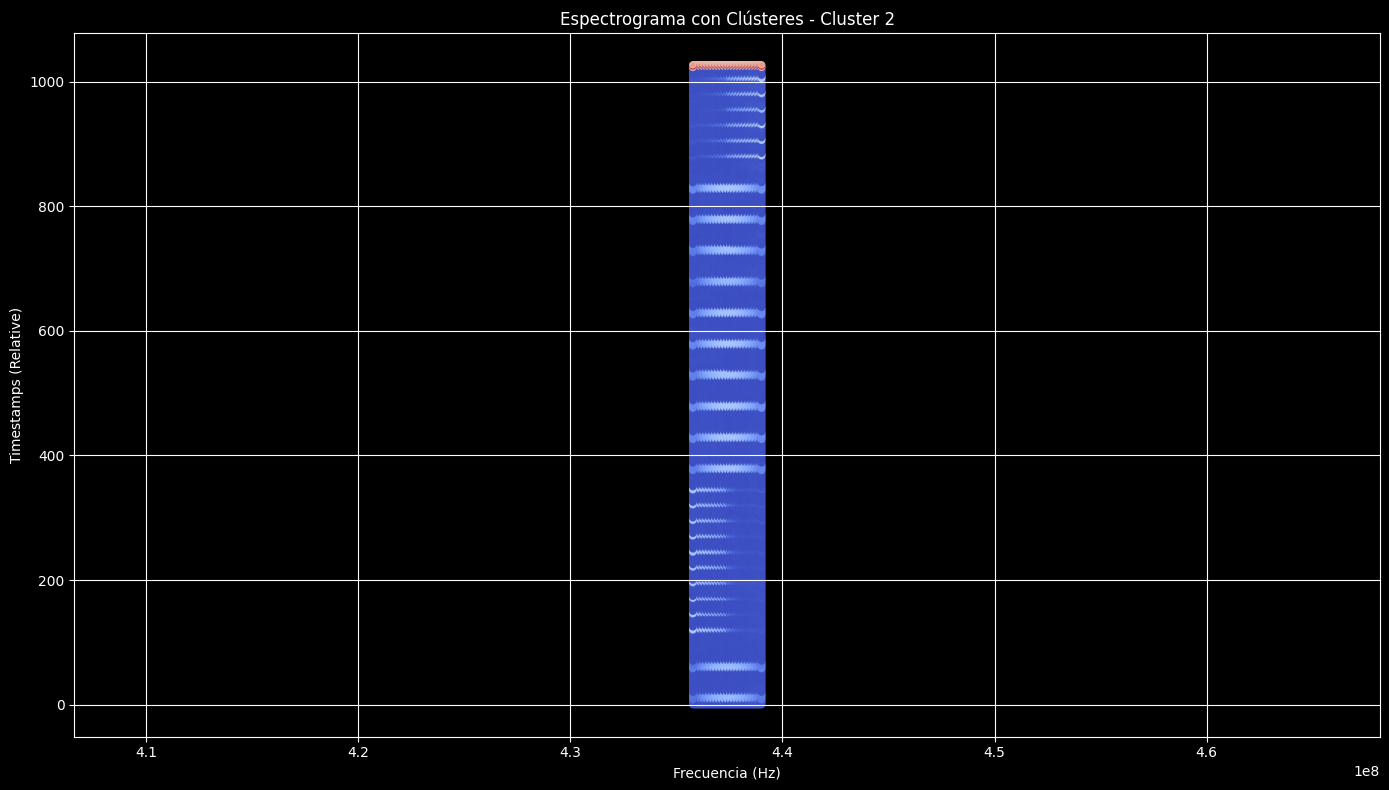

In [440]:
especSenal(2)

### Hallar frecuencias centrales

In [216]:
def calcularFrecuenciaCentral(valor):
  df_cluster = df_final[df_final['Cluster'] == valor]
  max_combined_score_index = df_cluster['combined_score'].idxmax()

  max_combined_score_frequency = pd.to_numeric(df_cluster.loc[max_combined_score_index].name)

  return max_combined_score_frequency

In [217]:
frec_senal1 = calcularFrecuenciaCentral(1)
frec_senal2 = calcularFrecuenciaCentral(2)

In [357]:
frec_senal2

437325231.619718

### Hallar BW

In [238]:
def calcularBW(cluster):
  df_cluster = df_final[df_final['Cluster'] == cluster]

  frequencies = pd.to_numeric(df_cluster.index)

  min_frequency = frequencies.min()
  max_frequency = frequencies.max()

  return max_frequency-min_frequency


In [239]:
bw_senal1 = calcularBW(1)
bw_senal2 = calcularBW(2)

In [359]:
bw_senal2

3239436.619718969

### Hallar amplitud/potencia

In [225]:
def calcularAmplitud(cluster):
  df_cluster = df_final[df_final['Cluster'] == cluster]

  # Encontrar la máxima amplitud en cada clúster
  max_amplitude = df_cluster.iloc[:, :-6].max().max()

  return max_amplitude


In [226]:
amp_senal1 = calcularAmplitud(1)
amp_senal2 = calcularAmplitud(2)

In [361]:
amp_senal2

-33.1003761291504

### Calcular nivel de ruido

In [366]:
def calcularNivelRuido(cluster):
  df_cluster = df_final[df_final['Cluster'] == cluster]

  noise_level = df_cluster.iloc[:, :-6].std().mean()

  return noise_level

In [367]:
ruido_senal1 = calcularNivelRuido(1)
ruido_senal2 = calcularNivelRuido(2)

In [369]:
ruido_senal1

5.277901604119923

### Calcular relación señal-ruido

In [234]:
def calcularSenalRuido(cluster):
  df_cluster = df_final[df_final['Cluster'] == cluster]

  noise_signal = df_cluster.iloc[:, :-6].std(axis=1).mean()

  return noise_signal


In [235]:
snr_senal1 = calcularSenalRuido(1)
snr_senal2 = calcularSenalRuido(2)

In [365]:
snr_senal2

14.409540375430156

### Visualizar forma de la señal

In [262]:
def visualizarFormaSenal(cluster):
  df_cluster = df_final[df_final['Cluster'] == cluster]

  frequencies = pd.to_numeric(df_cluster.index)

  plt.figure(figsize=(12, 6))

  for i, row in df_cluster.iterrows():
      plt.plot(df_cluster.columns[:-6], row[:-6], label=f'Freq: {i} Hz', alpha=0.6)

  plt.title(f'Señales en el Clúster {cluster}')
  plt.xlabel('Timestamps (Relative)')
  plt.ylabel('Amplitude [dBm]')
  plt.legend(loc='upper right')
  plt.grid(True)
  plt.show()

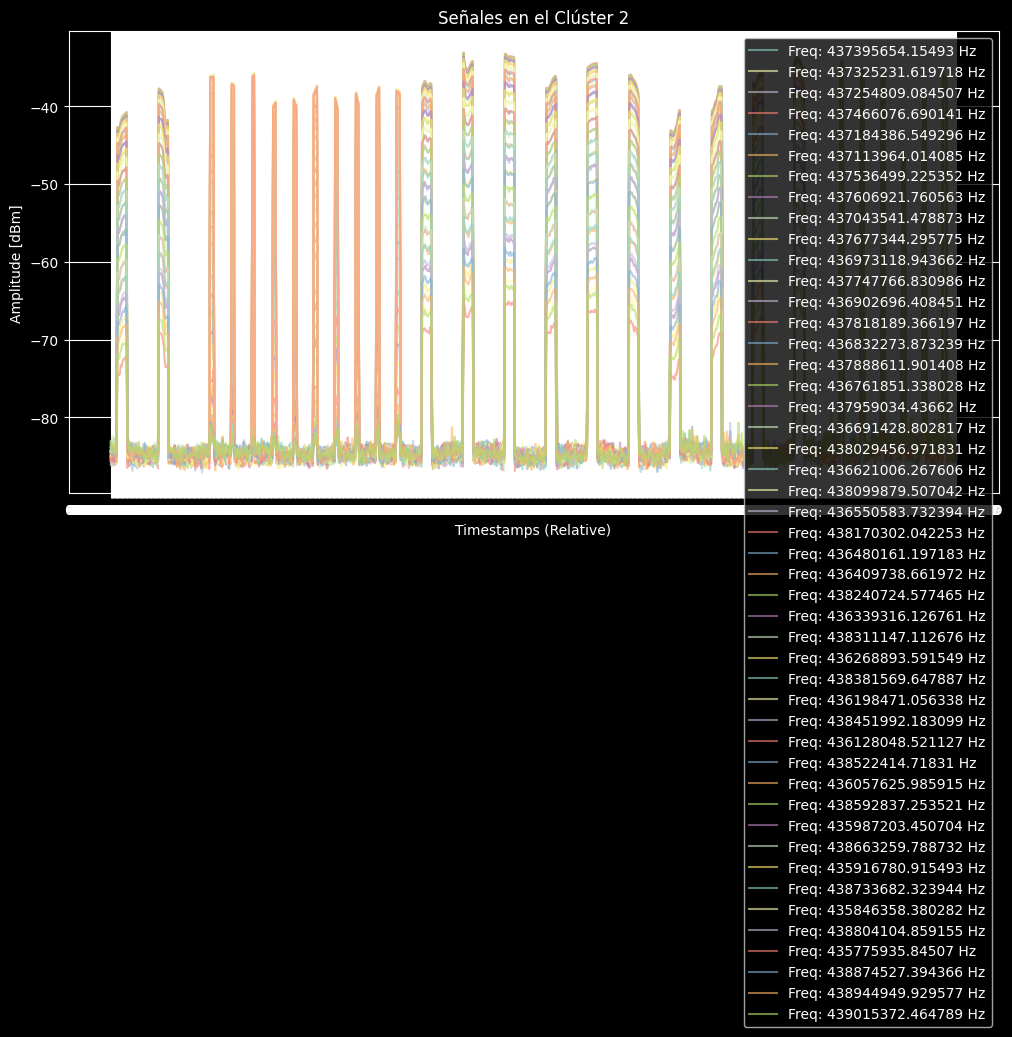

In [263]:
visualizarFormaSenal(2)

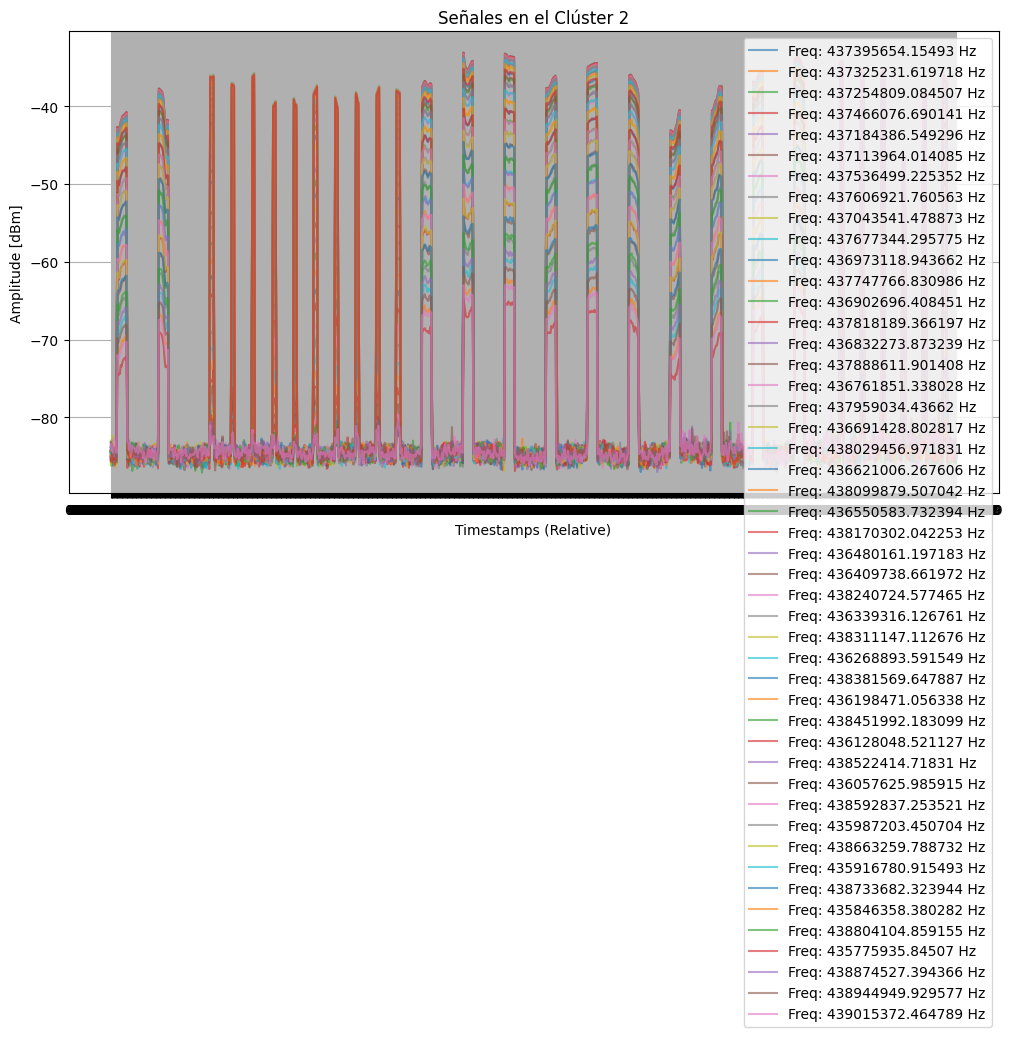

In [246]:
visualizarFormaSenal(2)

### Detectar picos espectrales

In [275]:
def calcularPicosEspectrales(cluster):
  df_cluster = df_final[df_final['Cluster'] == cluster].iloc[:, :-6]

  frequencies = pd.to_numeric(df_cluster.index)

  min_frequency = frequencies.min()
  max_frequency = frequencies.max()


  df_band = df_cluster[(pd.to_numeric(df_cluster.index) >= min_frequency) & (pd.to_numeric(df_cluster.index) <= max_frequency)]

  picos = df_band.idxmax(axis=1)
  amplitudes_maximas = df_band.max(axis=1)

  return list(zip(picos, amplitudes_maximas))

In [285]:
picos_senal1 = calcularPicosEspectrales(1)
picos_senal2 = calcularPicosEspectrales(2)

In [277]:
picos_senal1

[('00:00:07:956', -37.7391891479492),
 ('00:00:07:956', -37.7086715698242),
 ('00:00:07:956', -37.8734703063965),
 ('00:00:07:956', -37.7880172729492),
 ('00:00:07:956', -38.148136138916),
 ('00:00:07:956', -38.0077514648438),
 ('00:00:01:619', -38.6181221008301),
 ('00:00:07:956', -38.3007278442383),
 ('00:00:07:956', -39.0697975158691),
 ('00:00:07:956', -39.7106857299805),
 ('00:00:07:956', -38.6852607727051),
 ('00:00:07:956', -40.5346832275391),
 ('00:00:07:956', -39.2834243774414),
 ('00:00:07:956', -41.3769950866699),
 ('00:00:01:657', -39.8144493103027),
 ('00:00:07:956', -42.4390411376953),
 ('00:00:07:956', -40.6506538391113),
 ('00:00:01:657', -43.4827728271484),
 ('00:00:07:956', -41.4441375732422),
 ('00:00:01:657', -42.432933807373),
 ('00:00:07:956', -44.8194847106934),
 ('00:00:01:619', -43.5438079833984),
 ('00:00:01:619', -46.2355422973633),
 ('00:00:07:956', -44.7401351928711),
 ('00:00:01:657', -47.7248458862305),
 ('00:00:01:657', -46.0585327148438),
 ('00:00:01:65

### Crest factor

In [294]:
def calcularCrestFactor(cluster):
    peak_value = calcularAmplitud(cluster)
    rms_value = np.sqrt(np.mean(np.square(df_final.values)))
    crest_factor = peak_value / rms_value
    return crest_factor

In [295]:
crest_senal1 = calcularCrestFactor(1)
crest_senal2 = calcularCrestFactor(2)

In [296]:
crest_senal1

-0.4543732781403594

### Calcular frecuencia de repeticion de pulso

In [302]:
def calcularPrf(cluster, threshold=0.1):
    df_cluster = df_final[df_final['Cluster'] == cluster]
    prf = (df_cluster > threshold * df_cluster.max().max()).sum(axis=1).mean()
    return prf

In [303]:
prf_senal1 = calcularPrf(1)
prf_senal2 = calcularPrf(2)

### Calcular tiempo de ocupacion

In [353]:
def calcularOcupacion(cluster, threshold=0.1):
    df_cluster = df_final[df_final['Cluster'] == cluster]
    ocupacion = (df_cluster > threshold * df_cluster.max().max()).sum().sum()
    return ocupacion

In [354]:
ocup_senal1 = calcularOcupacion(1)

In [355]:
ocup_senal1

120

### Visualizar analisis de espectro temporal

In [370]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def waterfall_display(cluster):

    df_cluster = df_final[df_final['Cluster'] == cluster].iloc[:, :-6]

    if df_cluster.empty:
        print(f"No hay datos para el clúster {cluster}.")
        return

    frequencies = pd.to_numeric(df_cluster.index, errors='coerce')

    timestamps = df_cluster.columns
    timestamps_seconds = []
    for ts in timestamps:
        try:
            time_parts = ts.split(':')
            if len(time_parts) == 4:
                ts_formatted = f"{time_parts[0]}:{time_parts[1]}:{time_parts[2]}.{time_parts[3]}"
                timedelta = pd.to_timedelta(ts_formatted)
                seconds = timedelta.total_seconds()
                timestamps_seconds.append(seconds)
            else:
                raise ValueError(f"Formato inesperado: {ts}")
        except Exception as e:
            print(f"Error al convertir el timestamp {ts}: {e}")
            timestamps_seconds.append(np.nan)

    timestamps_seconds = np.array(timestamps_seconds)

    plt.figure(figsize=(12, 8))
    plt.style.use('dark_background')

    X, Y = np.meshgrid(timestamps_seconds, frequencies)
    plt.pcolormesh(X, Y, df_cluster.values, shading='auto', cmap='viridis')

    plt.xlabel('Time [s]', fontsize=12, color='white')
    plt.ylabel('Frequency [MHz]', fontsize=12, color='white')
    plt.title(f'Waterfall Display for Cluster {cluster}', fontsize=14, color='white')
    plt.colorbar(label='Amplitude [dBm]')

    plt.tight_layout()
    plt.show()


<ipython-input-334-9944b9793e85>:53: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(X, Y, df_cluster.values, shading='auto', cmap='viridis')  # Cambia 'viridis' según preferencia


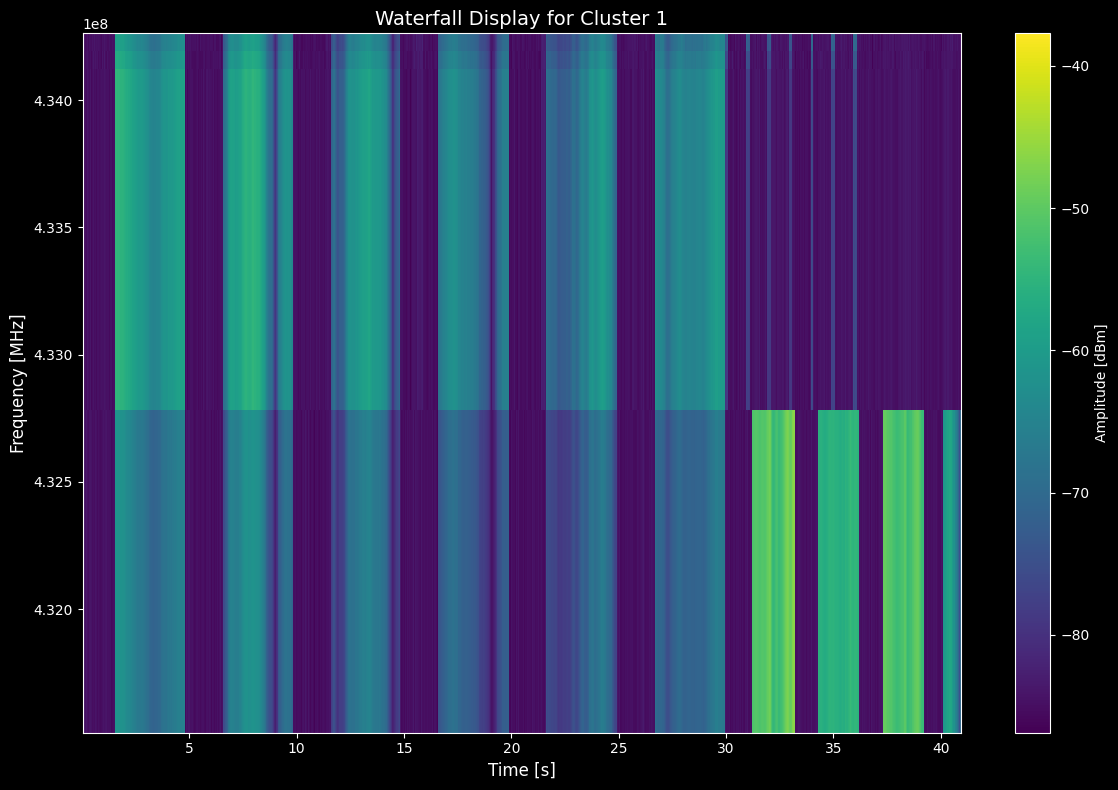

In [335]:
waterfall_display(1)

<ipython-input-334-9944b9793e85>:53: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(X, Y, df_cluster.values, shading='auto', cmap='viridis')  # Cambia 'viridis' según preferencia


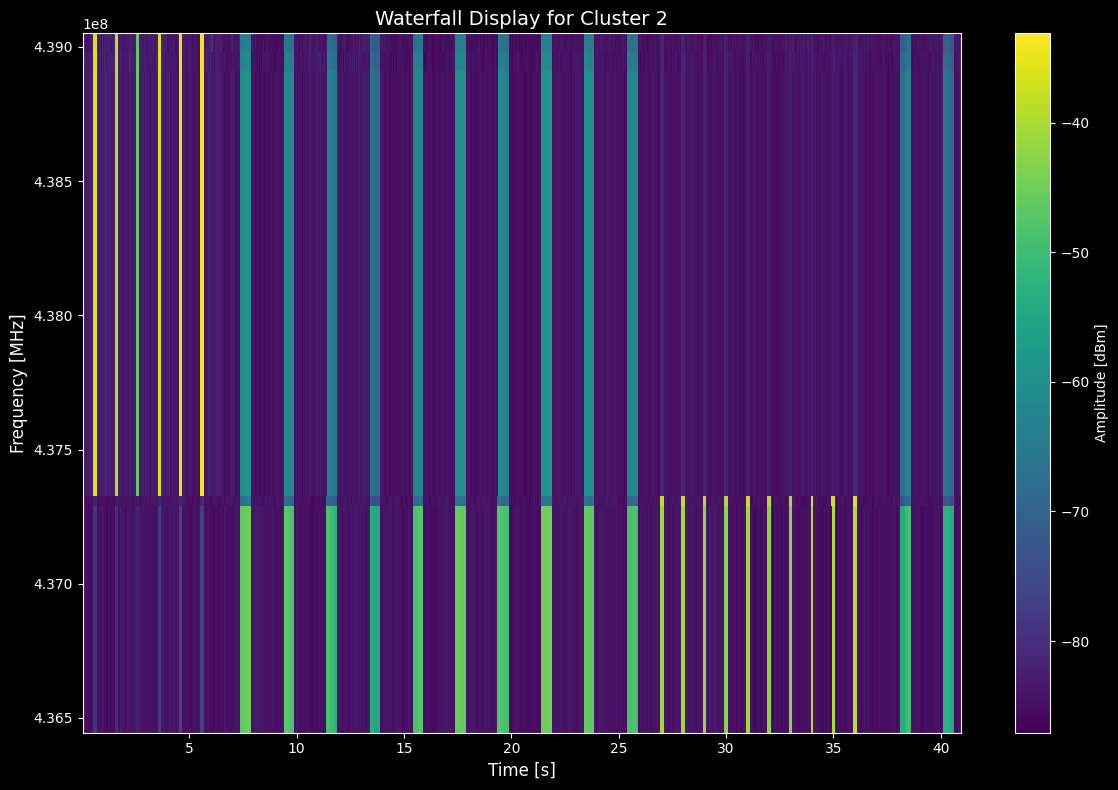

In [336]:
waterfall_display(2)

### Calcular potencia de canal

In [323]:
def calcularPotenciaCanal(cluster):
    df_cluster = df_final[df_final['Cluster'] == cluster]
    potencia = np.sum(np.square(df_cluster.values))
    return potencia

In [324]:
potcan_senal1 = calcularPotenciaCanal(1)
potcan_senal2 = calcularPotenciaCanal(2)

In [325]:
potcan_senal1

207163690.58104482

In [381]:
df_final

,00:00:40:899,00:00:40:859,00:00:40:810,00:00:40:762,00:00:40:726,00:00:40:691,00:00:40:658,00:00:40:619,00:00:40:562,00:00:40:528,...,00:00:00:178,00:00:00:139,00:00:00:099,00:00:00:059,00:00:00:000,std_dev,mean_diff,derivative,combined_score,Cluster
432959034.43662,-85.177162,-84.713280,-85.781425,-84.304329,-84.206673,-84.585098,-84.566788,-83.767204,-84.615616,-84.640038,...,-85.293129,-85.653252,-85.879089,-85.659355,-85.122223,19.009390,0.101844,52.334373,71.445607,1
432888611.901408,-85.317543,-84.786522,-85.451828,-84.560684,-84.139534,-84.328743,-84.237190,-83.895386,-83.529160,-84.603409,...,-85.647148,-85.647148,-85.689873,-85.189369,-84.304329,18.984943,0.101957,52.087156,71.174056,1
433029456.971831,-85.769218,-84.237190,-85.195473,-84.585098,-84.066284,-83.785515,-84.267708,-84.212776,-84.694969,-84.255501,...,-84.658348,-85.171059,-85.079498,-85.000153,-84.676659,18.957105,0.102372,51.978629,71.038106,1
432818189.366197,-85.702080,-85.781425,-85.567795,-85.543381,-84.365364,-83.877068,-84.963531,-83.712273,-83.144630,-83.547470,...,-84.743797,-85.427414,-85.378586,-84.200569,-84.243294,18.892331,0.102243,51.546450,70.541024,1
433099879.507042,-85.494553,-83.754997,-85.073395,-84.359261,-84.133430,-83.797722,-84.426407,-84.133430,-83.852654,-84.389786,...,-85.012360,-85.372475,-84.737694,-85.348061,-84.939117,18.831811,0.101981,52.089936,71.023727,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420987203.450704,-84.481339,-85.531174,-85.738701,-84.743797,-85.403000,-85.177162,-83.980835,-84.084595,-84.963531,-85.335854,...,-85.164955,-84.456924,-85.525070,-85.476242,-84.267708,0.469520,0.083041,42.972881,43.525442,0
421128048.521127,-84.554581,-84.157845,-85.207680,-85.341957,-84.633934,-84.792625,-84.603409,-85.213783,-84.908600,-85.116119,...,-84.603409,-85.744804,-85.543381,-84.908600,-84.701073,0.466313,0.083109,42.687456,43.236879,0
418944949.929577,-85.177162,-85.848564,-85.555588,-84.536270,-85.079498,-85.024567,-84.743797,-85.268715,-86.019470,-85.152748,...,-84.975739,-84.786522,-85.250404,-85.305336,-84.878082,0.460545,0.083712,42.882940,43.427198,0
420705513.309859,-84.951324,-84.884186,-85.000153,-84.884186,-84.713280,-84.292122,-84.975739,-85.262611,-85.103912,-85.421310,...,-84.676659,-84.469131,-85.415207,-84.823143,-84.426407,0.459328,0.083490,42.641236,43.184054,0
